In [1]:
import numpy as np #supporting multi-dimensional arrays and matrices
import os #read or write a file
import cv2  
import pandas as pd #data manipulation and analysis
from tqdm import tqdm # for  well-established ProgressBar
from random import shuffle #only shuffles the array along the first axis of a multi-dimensional array. The order of sub-arrays is changed but their contents remains the same.
LR = 1e-3
MODEL_NAME = 'plantclassfication-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which save

In [2]:
#data_dir = '../input/'
train_dir = os.path.join('train')
test_dir = os.path.join('test')
IMG_SIZE = 128

In [3]:
#list of categories in array format 
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
print (NUM_CATEGORIES)

12


In [4]:
''' function that accept plant category and return array format of the vlaue , one-hot array
 am sure there's better way to do this .......'''

def label_img(word_label):                       
    if word_label == 'Black-grass': return [1,0,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Charlock': return [0,1,0,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Cleavers': return [0,0,1,0,0,0,0,0,0,0,0,0]
    elif word_label == 'Common Chickweed': return [0,0,0,1,0,0,0,0,0,0,0,0]
    elif word_label == 'Common wheat': return [0,0,0,0,1,0,0,0,0,0,0,0]
    elif word_label == 'Fat Hen': return [0,0,0,0,0,1,0,0,0,0,0,0]
    elif word_label == 'Loose Silky-bent': return [0,0,0,0,0,0,1,0,0,0,0,0]
    elif word_label == 'Maize': return [0,0,0,0,0,0,0,1,0,0,0,0]
    elif word_label == 'Scentless Mayweed': return [0,0,0,0,0,0,0,0,1,0,0,0]
    elif word_label == 'Shepherds Purse': return [0,0,0,0,0,0,0,0,0,1,0,0]
    elif word_label == 'Small-flowered Cranesbill': return [0,0,0,0,0,0,0,0,0,0,1,0]
    elif word_label == 'Sugar beet': return [0,0,0,0,0,0,0,0,0,0,0,1]

In [5]:
'''function that will create train data , will go thought all the file do this 
----read the image in  grayscale mode ,resize it
---change it to numpy arrays and  append it to dataframe train with it`s associated category '''

def create_train_data():
    train = []
    for category_id, category in enumerate(CATEGORIES):
        for img in tqdm(os.listdir(os.path.join(train_dir, category))):
            label=label_img(category)
            path=os.path.join(train_dir,category,img)
            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            train.append([np.array(img),np.array(label)])
    shuffle(train)
    return train

In [6]:
train_data = create_train_data()

100%|██████████| 385/385 [00:08<00:00, 43.60it/s]


In [7]:
'''function that will create test data , will go thought  file do this 
----read the image in  grayscale mode ,resize it
---change it to numpy arrays and  append it to dataframe test but no category here of course  '''

def create_test_data():
    test = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir,img)
        img_num = img
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        test.append([np.array(img), img_num])
        
    shuffle(test)
    return test

In [8]:
test_data = create_test_data()

100%|██████████| 794/794 [00:05<00:00, 144.07it/s]


In [9]:
import tensorflow as tf #used for machine learning applications such as neural networks
import tflearn #modular and transparent deep learning library built on top of Tensorflow
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 12, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data
test = train_data

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3749  | total loss: 0.24611 | time: 41.549s
| Adam | epoch: 050 | loss: 0.24611 - acc: 0.9121 -- iter: 4736/4750
Training Step: 3750  | total loss: 0.25422 | time: 58.052s
| Adam | epoch: 050 | loss: 0.25422 - acc: 0.9115 | val_loss: 0.24735 - val_acc: 0.9149 -- iter: 4750/4750
--


In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/poriyalan/Desktop/vineeth/dudu ban ban/plantclassfication-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [11]:
#return Indexes of the maximal elements of a array
def label_return (model_out):
    if np.argmax(model_out) == 0: return  'Black-grass'
    elif np.argmax(model_out) == 1: return 'Charlock'
    elif np.argmax(model_out) == 2: return 'Cleavers'
    elif np.argmax(model_out) == 3: return 'Common Chickweed'
    elif np.argmax(model_out) == 4: return 'Common wheat'
    elif np.argmax(model_out) == 5: return 'Fat Hen'
    elif np.argmax(model_out) == 6: return 'Loose Silky-bent'
    elif np.argmax(model_out) == 7: return 'Maize'
    elif np.argmax(model_out) == 8: return 'Scentless Mayweed'
    elif np.argmax(model_out) == 9: return 'Shepherds Purse'
    elif np.argmax(model_out) == 10: return 'Small-flowered Cranesbill'
    elif np.argmax(model_out) == 11: return 'Sugar beet'
    


100%|██████████| 794/794 [00:02<00:00, 367.17it/s]


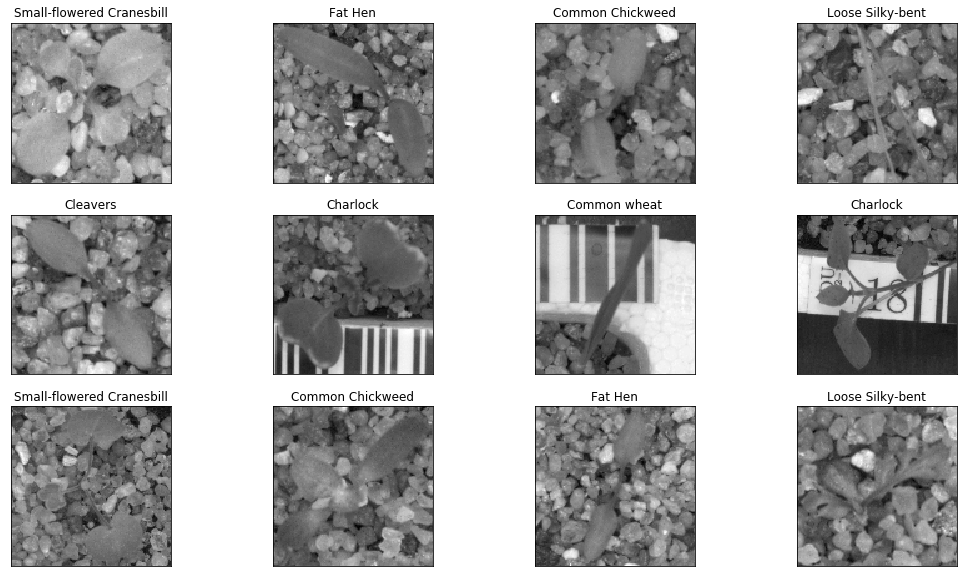

In [12]:
import matplotlib.pyplot as plt

test_data = create_test_data()
fig=plt.figure(figsize = (18,10))
for num,data in enumerate(test_data[:12]): 
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    str_label=label_return (model_out)
    y.imshow(orig,cmap='gray',interpolation='nearest')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [14]:
import pandas as pd
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head(2)

file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet

In [15]:
test_data = create_test_data()
with open('sample_submission.csv','w') as f:
    f.write('file,species\n')
    for data in test_data:
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        str_label=label_return (model_out)
        file = img_num
        species = str_label
        row = file + "," + species + "\n"
        f.write(row)

100%|██████████| 794/794 [00:02<00:00, 350.31it/s]


In [16]:
import pandas as pd
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head(10)

file                    species
0  e15472085.png                    Fat Hen
1  19fdf19fb.png                   Cleavers
2  80e299ae9.png                   Cleavers
3  0ebf8f2f4.png                      Maize
4  0c4199daa.png           Loose Silky-bent
5  cadab6616.png  Small-flowered Cranesbill
6  ef7a5651d.png           Loose Silky-bent
7  41e07778c.png                   Cleavers
8  4c7838de4.png                   Cleavers
9  00c47e980.png                 Sugar beet